#### Settings and imports

##### Imports

In [68]:
import pandas as pd
import pyranges as pr
import os
import numpy as np

In [69]:
from sklearn.preprocessing import MinMaxScaler
import umap
from tqdm import tqdm 
import matplotlib.pyplot as plt
from joblib import parallel_backend

In [70]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from collections import Counter
import igraph as ig
import leidenalg

##### Settings

In [71]:
# Set-up suppression of warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

#### Data load

In [72]:
chip_atlas_all_z_dna = pd.read_csv('../data/Umap/Experiment_and_predicted_z_dna_ Neural_omics.csv', index_col=0)
polycomb_anchors = pd.read_table('../data/polycomb_dot_anchors.bed')

In [73]:
chip_atlas_all_z_dna

,Chromosome,Start,End,value_RNA_polymerase_II,value_TP53,value_OTX2,value_ESRRG,value_CHD7,value_ARNTL,value_PPARA,...,value_H4K5K8ac,value_H3,value_H3K4me1,value_H3K9me1,value_CENPA,value_H3K122ac,value_H3K4me,value_H4K16ac,value_H3R8me2,value_DNase-Seq
0,chr1,923765,923784,0,0,0,0,0,0,0,...,0,0,57,0,0,0,0,0,0,38
1,chr1,923803,923913,54,0,0,0,0,0,0,...,0,0,718,0,0,0,0,0,0,1570
2,chr1,924508,925162,0,0,0,0,0,0,0,...,1139,0,2726,0,0,0,0,0,0,211
3,chr1,936222,936233,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr1,940512,940745,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75224,chrY,323544,323592,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75225,chrY,323680,323724,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75226,chrY,323807,323835,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75227,chrY,323923,323949,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Add flag=True for regions overlap with polycomb anchors
polycomb_anchors.columns = ['Chromosome', 'Start', 'End', 'Gene']

zdna_coords = chip_atlas_all_z_dna[['Chromosome', 'Start', 'End']].copy()
zdna_coords['idx'] = zdna_coords.index
zdna_ranges = pr.PyRanges(zdna_coords)
polycomb_ranges = pr.PyRanges(polycomb_anchors)
intersected = zdna_ranges.join(polycomb_ranges)
# Indexes of intersecting elements
intersected_indices = set(intersected.df['idx'])
chip_atlas_all_z_dna['flag'] = chip_atlas_all_z_dna.index.isin(intersected_indices)

In [75]:
chip_atlas_all_z_dna.flag.sum()

1544

In [76]:
# Filter z-dna regions not overlap with omics features (zero values)
print("Before:", len(chip_atlas_all_z_dna))
chip_atlas_all_z_dna_filtered = chip_atlas_all_z_dna[(chip_atlas_all_z_dna.iloc[:, 3:] != 0).any(axis=1)]
print("After:", len(chip_atlas_all_z_dna_filtered))

Before: 75229
After: 62830


In [77]:
def count_non_null_values(df):
    non_zero_counts = {}
    for col in df.columns:
        non_zero_counts[col] = (df[col] != 0).sum()
    return non_zero_counts
count_non_null_values(chip_atlas_all_z_dna_filtered) # many omics features not overlap with z-dna regions

{'Chromosome': 62830,
 'Start': 62830,
 'End': 62830,
 'value_RNA_polymerase_II': 20392,
 'value_TP53': 10,
 'value_OTX2': 371,
 'value_ESRRG': 34,
 'value_CHD7': 225,
 'value_ARNTL': 1393,
 'value_PPARA': 12,
 'value_POU3F2': 7,
 'value_STAG2': 957,
 'value_LHX2': 1,
 'value_CDYL': 357,
 'value_SS18': 4,
 'value_TFAP2A': 266,
 'value_TEAD1': 69,
 'value_TEAD4': 369,
 'value_PITX3': 99,
 'value_OLIG2': 2254,
 'value_ZNF8': 34,
 'value_HAND2': 447,
 'value_STAG3': 0,
 'value_SUZ12': 259,
 'value_CHAT': 6,
 'value_E2F1': 1346,
 'value_PSIP1': 5,
 'value_SIN3A': 418,
 'value_TOP2A': 1,
 'value_CHD2': 794,
 'value_FOXC1': 20,
 'value_EHMT2': 25,
 'value_RBPJ': 141,
 'value_GTF3C5': 396,
 'value_RNF2': 150,
 'value_RCOR1': 34,
 'value_CHD8': 2586,
 'value_INSR': 3,
 'value_PAX6': 66,
 'value_INTS13': 3774,
 'value_SMARCC1': 4,
 'value_FANCD2': 418,
 'value_BRD4': 5339,
 'value_ZNF565': 15,
 'value_Epitope_tags': 4234,
 'value_KAT2A': 51,
 'value_IRF3': 18,
 'value_ELF1': 1322,
 'value_ARID1

In [78]:
# we will discard omics features with many zero values to allow UMAP to produce a meaningful 2D projection
def filter_zero_values(matrix_df: pd.DataFrame, row_zero_threshold_percent: float)-> pd.DataFrame:
    """
    Function to filter a DataFrame by rows based on the percentage of zeros

    Args:
    matrix_df (DataFrame): The input DataFrame
    row_zero_threshold_percent (float): Maximum allowed percentage of zeros in a row

    Returns:
    filtered_df (DataFrame): The filtered DataFrame
    """
    data_columns = [col for col in matrix_df.columns[3:] if col != 'flag']
   
    zero_counts = (matrix_df[data_columns] == 0).sum(axis=1)
    zero_percent = 100 * zero_counts / len(data_columns)

    # Filter rows based on zero percentage condition; keep all columns, including 'flag'
    filtered_df = matrix_df.loc[zero_percent <= row_zero_threshold_percent].copy()

    return filtered_df



In [79]:
filtered_z_dna_df = filter_zero_values(chip_atlas_all_z_dna_filtered, row_zero_threshold_percent=95.0)

In [80]:
filtered_z_dna_df

,Chromosome,Start,End,value_RNA_polymerase_II,value_TP53,value_OTX2,value_ESRRG,value_CHD7,value_ARNTL,value_PPARA,...,value_H3,value_H3K4me1,value_H3K9me1,value_CENPA,value_H3K122ac,value_H3K4me,value_H4K16ac,value_H3R8me2,value_DNase-Seq,flag
2,chr1,924508,925162,0,0,0,0,0,0,0,...,0,2726,0,0,0,0,0,0,211,False
12,chr1,1019671,1019869,990,0,0,0,0,0,0,...,0,7920,0,0,0,0,0,0,7464,False
37,chr1,1231879,1231954,1849,0,0,0,0,0,0,...,0,3186,0,0,448,0,269,0,5788,False
38,chr1,1231974,1232092,1678,0,0,0,0,0,0,...,0,474,0,0,89,0,0,0,85904,False
39,chr1,1232584,1232739,0,0,0,0,0,0,0,...,0,3156,0,0,0,0,155,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75205,chr9,137845513,137845533,20,0,0,0,0,0,0,...,80,60,0,0,0,0,0,0,180,False
75206,chr9,137845575,137845595,20,0,0,0,0,0,0,...,80,60,0,0,0,0,0,0,180,False
75207,chr9,137845637,137845657,20,0,0,0,0,0,0,...,80,60,0,0,0,0,0,0,180,False
75208,chr9,137845699,137845719,20,0,0,0,0,0,0,...,80,60,0,0,0,0,0,0,180,False


### UMAP

In [81]:
RANDOM_STATE = 42

param_grid = {
    'n_neighbors': [55],
    'min_dist': [0.1, 0.2, 0.5],
    'metric': ['manhattan']
}

def main(zdna_matrix, row_zero_threshold_percent=0, output_dir='../data/Umap/umap_embeddings'):
    """
    Perform UMAP dimensionality reduction on the input zdna_matrix using specified hyperparameters,
    save the resulting embeddings and scatter plots for each parameter combination.

    Parameters:
    ----------
    zdna_matrix : pd.DataFrame
        Input data containing features for UMAP and metadata columns including 'flag', 'Chromosome', 'Start', 'End'.
    row_zero_threshold_percent : float, optional
        Threshold percentage to indicate filtering of rows with zero values (default is 0, no filtering).
    output_dir : str, optional
        Directory path where embedding files and plots will be saved (default is 'umap_embeddings_').

    Outputs:
    -------
    Saves UMAP embedding results as TSV files and corresponding scatter plots as PNG images in the output directory.
    """

    filtering_used = row_zero_threshold_percent > 0
    omics_columns = zdna_matrix.columns.difference(['flag', 'Chromosome', 'Start', 'End'])
    omics_matrix = zdna_matrix[omics_columns]

    flags = zdna_matrix['flag']
    total_features = omics_matrix.shape[0]
    structure_in_polycomb = (flags == True).sum()

    scaler = MinMaxScaler()
    zdna_scaled = scaler.fit_transform(omics_matrix)

    print("Running UMAP with different hyperparameters...")

    total_runs = len(param_grid['n_neighbors']) * len(param_grid['min_dist']) * len(param_grid['metric'])
    outer_pbar = tqdm(total=total_runs, desc='UMAP combinations')

    fig_count = 0
    os.makedirs(output_dir, exist_ok=True)

    for n_neighbors in param_grid['n_neighbors']:
        for min_dist in param_grid['min_dist']:
            for metric in param_grid['metric']:
                with parallel_backend('loky', n_jobs=8):
                    reducer = umap.UMAP(
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        metric=metric,
                        random_state=RANDOM_STATE
                    )

                    try:
                        embedding = reducer.fit_transform(zdna_scaled)

                        result_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
                        result_df['region_id'] = range(len(result_df))
                        result_df['flag'] = flags.values
                        result_df['Start'] = zdna_matrix['Start'].values
                        result_df['End'] = zdna_matrix['End'].values

                        fname = f"umap_n{n_neighbors}_d{min_dist}_m{metric}.tsv"
                        out_path = os.path.join(output_dir, fname)
                        result_df.to_csv(out_path, sep='\t', index=False)

                        print(f"Saved file: {out_path}")
                        filtering_text = (f"Filtering: rows ≤ {row_zero_threshold_percent}%, " 
                                          if filtering_used else "Filtering: none")

                        summary_title = (f"Secondary DNA structures: {total_features} | "
                                         f"In neuronal sites: {structure_in_polycomb} | {filtering_text}")

                        plt.figure(figsize=(10, 8))
                        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.6, s=1, cmap='Spectral')
                        umap_params_text = f"UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}"
                        plt.title(f"{summary_title}\n{umap_params_text}", fontsize=12)
                        plt.xlabel('UMAP1')
                        plt.ylabel('UMAP2')
                        plt.grid(True)

                        fig_fname = f"umap_n{n_neighbors}_d{min_dist}_m{metric}.png"
                        fig_path = os.path.join(output_dir, fig_fname)
                        plt.savefig(fig_path, dpi=300)
                        plt.show() 
                        plt.close()

                        print(f"Saved plot: {fig_path}")

                        fig_count += 1
                    except Exception as e:
                        print(f"Error in parameters n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}: {e}")
                    outer_pbar.update(1)

    outer_pbar.close()
    print(f"Total plots: {fig_count}")
    print(f"Embeddings and plots saved in: {output_dir}")


Running UMAP with different hyperparameters...


UMAP combinations:   0%|          | 0/3 [00:00<?, ?it/s]

Saved file: ../data/Umap/umap_embeddings/umap_n55_d0.1_mmanhattan.tsv


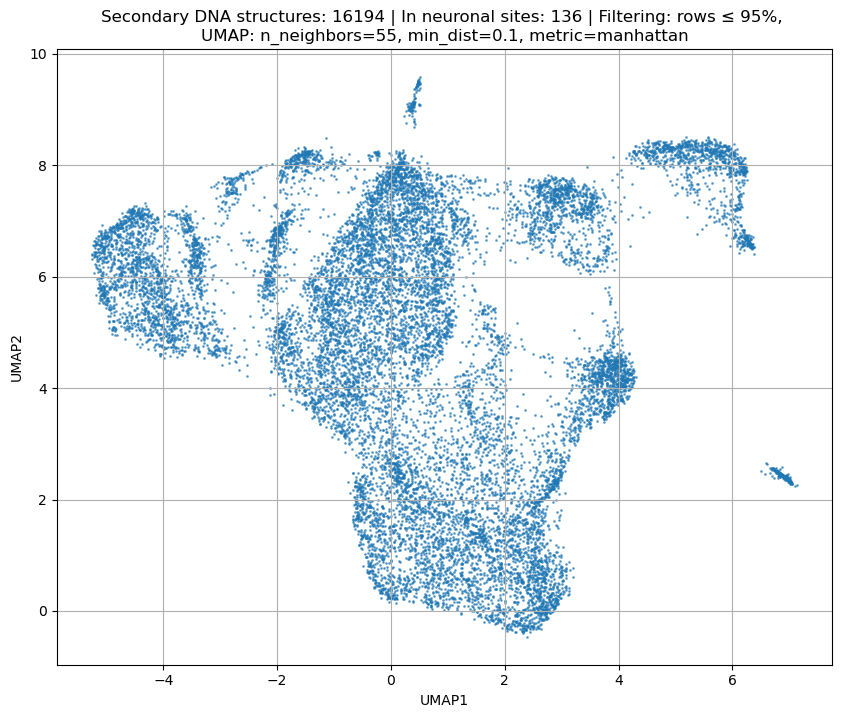

UMAP combinations:  33%|███▎      | 1/3 [00:37<01:14, 37.20s/it]

Saved plot: ../data/Umap/umap_embeddings/umap_n55_d0.1_mmanhattan.png
Saved file: ../data/Umap/umap_embeddings/umap_n55_d0.2_mmanhattan.tsv


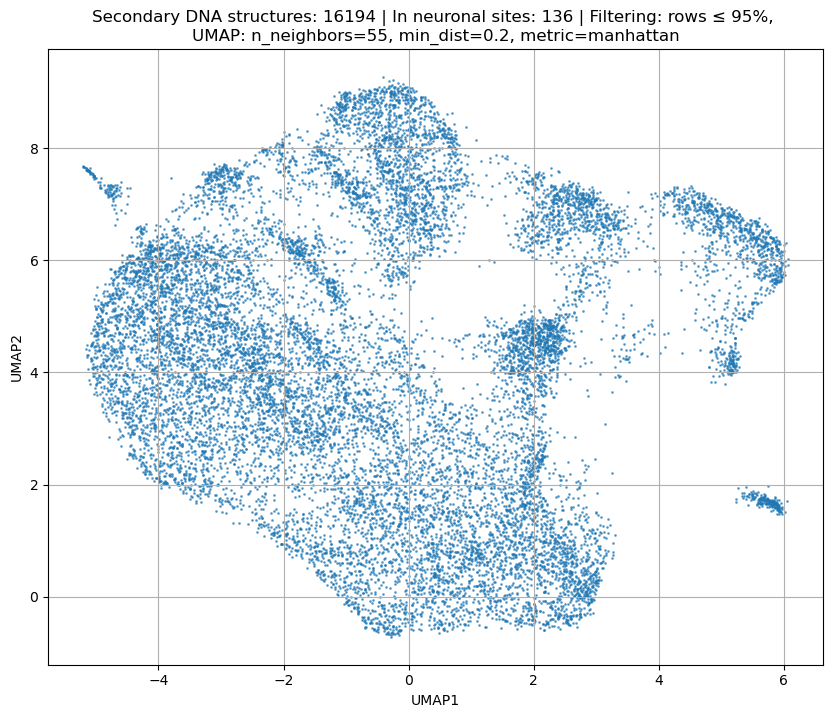

UMAP combinations:  67%|██████▋   | 2/3 [00:55<00:26, 26.16s/it]

Saved plot: ../data/Umap/umap_embeddings/umap_n55_d0.2_mmanhattan.png
Saved file: ../data/Umap/umap_embeddings/umap_n55_d0.5_mmanhattan.tsv


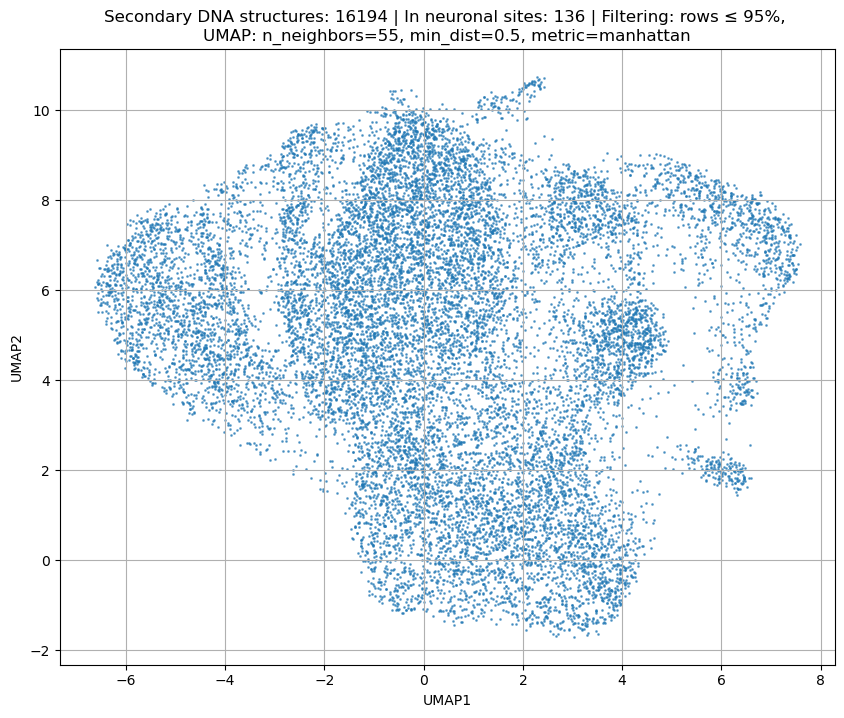

UMAP combinations: 100%|██████████| 3/3 [01:13<00:00, 24.36s/it]

Saved plot: ../data/Umap/umap_embeddings/umap_n55_d0.5_mmanhattan.png
Total plots: 3
Embeddings and plots saved in: ../data/Umap/umap_embeddings


In [82]:
main(filtered_z_dna_df, row_zero_threshold_percent=95)

### Leiden clusterization

In [83]:
def run_leiden_from_umap(tsv_path, neighbor_values, resolution_values, output_dir='../data/Umap/umap_embeddings', min_cluster_size=50):
    """
    Run Leiden clustering on UMAP embeddings from TSV file and save results.

    Args:
        tsv_path (str): Path to TSV with UMAP embeddings.
        neighbor_values (list): List of n_neighbors for KNN graph.
        resolution_values (list): List of resolution parameters for Leiden.
        output_dir (str): Directory to save results.
        min_cluster_size (int): Minimum cluster size to keep.

    """
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(tsv_path, sep='\t')
    embedding = df[['UMAP_1', 'UMAP_2']].values 

    total_runs = len(neighbor_values) * len(resolution_values)
    print(f"Всего комбинаций: {total_runs}")

    results = []

    for n_neighbors in neighbor_values:
        knn = NearestNeighbors(n_neighbors=n_neighbors)
        knn.fit(embedding)
        _, indices = knn.kneighbors(embedding)

        edges = []
        for i, neighbors in enumerate(indices):
            for j in neighbors[1:]:
                edges.append((i, j))

        g = ig.Graph(edges=edges, directed=False)

        for resolution in resolution_values:
            partition = leidenalg.find_partition(
                g,
                leidenalg.RBConfigurationVertexPartition,
                resolution_parameter=resolution
            )

            labels = np.array(partition.membership)
            counts = Counter(labels)

            # Removing small clusters
            valid_clusters = {label for label, count in counts.items() if count >= min_cluster_size}
            labels_filtered = np.array([label if label in valid_clusters else -1 for label in labels])

            mask = labels_filtered != -1
            if len(set(labels_filtered[mask])) > 1:
                sil_score = silhouette_score(embedding[mask], labels_filtered[mask])
            else:
                sil_score = -1

            results.append({
                'n_neighbors': n_neighbors,
                'resolution': resolution,
                'n_clusters': len(set(labels_filtered)) - (1 if -1 in labels_filtered else 0),
                'silhouette': sil_score,
                'labels': labels_filtered
            })

            print(f"n_neighbors={n_neighbors}, resolution={resolution:.2f} → "
                  f"{results[-1]['n_clusters']} clusters, silhouette = {sil_score:.3f}")
            result_df = df.copy()
            result_df['leiden_cluster'] = labels_filtered
            outname = f"leiden_n{n_neighbors}_res{resolution:.2f}.tsv"
            result_df.to_csv(os.path.join(output_dir, outname), sep='\t', index=False)

    print(f"\n Results saved in folder: {output_dir}")

In [84]:
run_leiden_from_umap('../data/Umap/umap_embeddings/umap_n55_d0.1_mmanhattan.tsv', neighbor_values=[100, 150, 200],
    resolution_values=[0.1, 0.25, 1.0],
    output_dir='../data/Umap/umap_embeddings')

Всего комбинаций: 9
n_neighbors=100, resolution=0.10 → 9 clusters, silhouette = 0.408
n_neighbors=100, resolution=0.25 → 12 clusters, silhouette = 0.411
n_neighbors=100, resolution=1.00 → 25 clusters, silhouette = 0.412
n_neighbors=150, resolution=0.10 → 8 clusters, silhouette = 0.415
n_neighbors=150, resolution=0.25 → 10 clusters, silhouette = 0.421
n_neighbors=150, resolution=1.00 → 19 clusters, silhouette = 0.416
n_neighbors=200, resolution=0.10 → 6 clusters, silhouette = 0.447
n_neighbors=200, resolution=0.25 → 8 clusters, silhouette = 0.438
n_neighbors=200, resolution=1.00 → 17 clusters, silhouette = 0.400

 Results saved in folder: ../data/Umap/umap_embeddings


In [85]:
def plot_leiden_from_file(tsv_path, cluster_col='leiden_cluster', flag_col='flag', save_path=None):
    """
    Plot Leiden clustering results from TSV file (minimalist version) with legend.
    
    Args:
        tsv_path (str): Path to TSV with UMAP embeddings and cluster labels.
        cluster_col (str): Column name for cluster labels.
        flag_col (str): Column name for flag to highlight points.
        save_path (str or None): If given, save plot to this path, else show.
    """

    df = pd.read_csv(tsv_path, sep='\t')
    embedding = df[['UMAP_1', 'UMAP_2']].values
    labels = df[cluster_col].values
    flags = df[flag_col].values

    plt.figure(figsize=(10, 8), facecolor='white')
    ax = plt.gca()

    ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)

    cluster_colors = {
        -1: '#d3d3d3',  
        0: '#1f77b4',   
        1: "#f69845",   
        2: '#bcbd22',
        3: "#6bb96b",
        4: '#9467bd',   
        5: "#a2736a",  
        6: '#e377c2',   
        7: '#7f7f7f',   
        9: '#17becf'    
    }

    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        idx = labels == cluster
        color = cluster_colors.get(cluster, '#7f7f7f')  
        ax.scatter(embedding[idx, 0], embedding[idx, 1], 
                   color=color, s=5, alpha=0.7, linewidths=0)

    
    flag_idx = flags == True
    ax.scatter(embedding[flag_idx, 0], embedding[flag_idx, 1], edgecolors='black', linewidths=0.5,
               color='#ff0000', s=20, alpha=0.9)

    from matplotlib.lines import Line2D
    legend_elements = []
    for cluster in sorted(unique_clusters):
        color = cluster_colors.get(cluster, '#7f7f7f')
        label = f'Cluster {cluster}'
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label,
                                      markerfacecolor=color, markersize=10))
        

    legend_elements.append(
        Line2D([0], [0], marker='o', color='black', label='Z-DNA in polycomb',
               markerfacecolor="#ff0000", markersize=10, markeredgewidth=0.5)
    )

    ax.legend(handles=legend_elements, loc='lower left', fontsize=19, frameon=False)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
        print(f'Saved in {save_path}')
    else:
        plt.show()
    plt.close()


In [86]:
plot_leiden_from_file('../data/Umap/umap_embeddings/leiden_n200_res0.25.tsv', save_path='../data/Umap/umap_embeddings/leiden_clusters_n200_res0.25.png')

Saved in ../data/Umap/umap_embeddings/leiden_clusters_n200_res0.25.png


In [87]:
df = pd.read_csv('../data/Umap/umap_embeddings/leiden_n200_res0.25.tsv', sep='\t')
total_structures = len(df)
total_polycomb = df['flag'].sum()

summary = (
    df.groupby('leiden_cluster')
    .agg(
        total_in_cluster=('flag', 'count'),
        polycomb_true=('flag', 'sum')
    )
    .reset_index()
)

summary['% of Z-DNA intersect with polycomb within cluster'] = summary['polycomb_true'] / summary['total_in_cluster'] * 100
summary['% of all polycomb-intersecting Z-DNA'] = summary['polycomb_true'] / total_polycomb * 100
summary['Cluster proportion of all Z-DNA'] = summary['total_in_cluster'] / total_structures * 100

summary = summary.rename(columns={
    'leiden_cluster': 'Cluster',
    'total_in_cluster': 'Total Z-DNA',
    'polycomb_true': 'Intersect with polycomb'
})
summary = summary.round(2)
summary = summary[
    ['Cluster',
     'Total Z-DNA',
     'Cluster proportion of all Z-DNA',
     '% of all polycomb-intersecting Z-DNA',
     'Intersect with polycomb',
     '% of Z-DNA intersect with polycomb within cluster',
     ]
]
summary = summary.sort_values(by='% of Z-DNA intersect with polycomb within cluster', ascending=False)
display(summary)  


,Cluster,Total Z-DNA,Cluster proportion of all Z-DNA,% of all polycomb-intersecting Z-DNA,Intersect with polycomb,% of Z-DNA intersect with polycomb within cluster
5,5,1015,6.27,13.24,18,1.77
1,1,3352,20.70,40.44,55,1.64
6,6,964,5.95,9.56,13,1.35
0,0,4618,28.52,22.06,30,0.65
3,3,2099,12.96,8.82,12,0.57
7,7,809,5.00,2.94,4,0.49
2,2,2150,13.28,2.94,4,0.19
4,4,1187,7.33,0.00,0,0.00


### Compare feature both within and outside each cluster, utilizing Z-statistics

In [88]:
leiden_df = pd.read_csv('../data/Umap/umap_embeddings/leiden_n200_res0.25.tsv', sep='\t')

In [89]:
leiden_df

,UMAP_1,UMAP_2,region_id,flag,Start,End,leiden_cluster
0,-0.050657,0.394597,0,False,924508,925162,0
1,0.268370,1.883301,1,False,1019671,1019869,0
2,1.046759,1.617168,2,False,1231879,1231954,0
3,2.056039,2.454175,3,False,1231974,1232092,0
4,-0.506758,1.995349,4,False,1232584,1232739,0
...,...,...,...,...,...,...,...
16189,-2.014098,7.245483,16189,False,137845513,137845533,7
16190,-2.035955,7.273151,16190,False,137845575,137845595,7
16191,-2.027760,7.301840,16191,False,137845637,137845657,7
16192,-2.059300,7.286206,16192,False,137845699,137845719,7


In [90]:
def compute_feature_z_scores(feature_matrix, cluster_labels):
    """
    Compute z-scores of features for each cluster vs. rest.
    Args:
        feature_matrix (pd.DataFrame): DataFrame with features and optional 'flag' column.
        cluster_labels (np.array or list): Cluster labels for each row, -1 denotes noise.

    Returns:
        pd.DataFrame: Concatenated DataFrame with features sorted by descending z-score per cluster.
    """

    feature_names = [f for f in feature_matrix.columns if f != 'flag']
    feature_array = feature_matrix[feature_names].values
    feature_names_arr = np.array(feature_names)
    unique_clusters = np.unique(cluster_labels)
    unique_clusters = unique_clusters[unique_clusters != -1]

    cluster_z_dict = {}

    for cluster in unique_clusters:
        in_cluster = feature_array[cluster_labels == cluster]
        out_cluster = feature_array[cluster_labels != cluster]

        z_scores = []
        for i in range(len(feature_names)):
            mean_in = np.mean(in_cluster[:, i])
            mean_out = np.mean(out_cluster[:, i])
            std_out = np.std(out_cluster[:, i])

            if std_out == 0:
                z = 0
            else:
                z = (mean_in - mean_out) / std_out

            z_scores.append(z)

        cluster_z_dict[cluster] = z_scores

    df_parts = []
    for cluster in unique_clusters:
        z_scores = np.array(cluster_z_dict[cluster])
        sorted_indices = np.argsort(-z_scores)
        sorted_features = feature_names_arr[sorted_indices]
        sorted_z_scores = z_scores[sorted_indices]

        cluster_col_name = f'cluster {cluster}'
        cluster_col = pd.Series(sorted_features, name=cluster_col_name)
        z_score_col_name = f'z-score {cluster}'

        z_score_col = pd.Series(sorted_z_scores, name=z_score_col_name)
        df_cluster = pd.concat([cluster_col, z_score_col], axis=1)
        df_parts.append(df_cluster)

    df_result = pd.concat(df_parts, axis=1)
    assert len(cluster_labels) == feature_matrix.shape[0], "Number of labels and regions not the same"

    return df_result



In [91]:
omics_columns = filtered_z_dna_df.columns.difference(['Chromosome', 'Start', 'End', 'flag'])
omics_data = filtered_z_dna_df[omics_columns]
cluster_labels = leiden_df['leiden_cluster'].values
z_scores_df = compute_feature_z_scores(omics_data, cluster_labels)
z_scores_df

,cluster 0,z-score 0,cluster 1,z-score 1,cluster 2,z-score 2,cluster 3,z-score 3,cluster 4,z-score 4,cluster 5,z-score 5,cluster 6,z-score 6,cluster 7,z-score 7
0,value_TAF1,8.661213,value_CDYL,0.578229,value_BRD3,0.086829,value_GFP,0.393177,value_GTF3C5,3.504484,value_RAD21,3.528704,value_H4K12ac,0.437967,value_KAT2A,0.167504
1,value_NEUROD1,6.959436,value_PSIP1,0.568178,value_ZNF92,0.041175,value_BMI1,0.129395,value_ATF3,2.413517,value_SMC1A,2.816426,value_CTCFL,0.142146,value_ASCL1,0.149329
2,value_RNA_polymerase_II,6.775403,value_H3K27me2,0.317090,value_SATB1,0.028505,value_H3K9me1,0.046883,value_GTF3C2,1.551926,value_STAG2,2.409590,value_CTCF,0.120060,value_H3K9me1,0.148748
3,value_H3K9ac,6.284242,value_SOX3,0.239106,value_CHAT,0.023630,value_MCM3,0.032401,value_TEAD4,1.372004,value_STAG1,2.049427,value_POU3F2,0.115944,value_ATRX,0.120253
4,value_SMARCC2,6.001941,value_H3K36me2,0.121977,value_MECP2,0.011571,value_HDAC1,0.031691,value_DYRK1A,1.355740,value_SMC3,1.927235,value_TBX2,0.054031,value_MCM3,0.093673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,value_CDYL,-0.040231,value_DNase-Seq,-0.412668,value_MAX,-0.343132,value_MAX,-0.367449,value_H3K9K14ac,-0.282484,value_H3K9K14ac,-0.326022,value_H3K9K14ac,-0.355344,value_H3K27ac,-0.374098
248,value_ATF3,-0.059486,value_H3K27ac,-0.415205,value_RNA_polymerase_II,-0.344311,value_H3K9ac,-0.367875,value_TAF1,-0.283501,value_H3K27ac,-0.334804,value_H3K27ac,-0.370498,value_DNase-Seq,-0.381606
249,value_SMC1A,-0.060075,value_H3K9ac,-0.450778,value_H3K4me1,-0.351671,value_DNase-Seq,-0.410646,value_H3K4me3,-0.300253,value_H3K9ac,-0.368586,value_H3K9ac,-0.405402,value_H3K9ac,-0.395484
250,value_GTF3C5,-0.088888,value_H3K4me1,-0.500138,value_H3K4me3,-0.358118,value_H3K4me1,-0.416353,value_H4K5ac,-0.305279,value_H3K4me1,-0.370381,value_H3K4me1,-0.429665,value_H3K4me1,-0.412580


In [92]:
z_scores_df.to_csv('../data/Umap/umap_embeddings/z_score_leiden_clusters_0.25res_200_nn.tsv')

In [93]:
def extract_top_positive_features(z_scores_df, top_n=5):
    top_features = {}
    num_clusters = z_scores_df.shape[1] // 2 

    for i in range(num_clusters):
        cluster_col = z_scores_df.columns[2 * i]
        z_score_col = z_scores_df.columns[2 * i + 1]
        cluster_num = int(cluster_col.split()[-1])
        cluster_df = z_scores_df[[cluster_col, z_score_col]].dropna()

        if cluster_df[z_score_col].iloc[0] <= 0:
            continue
        positive_df = cluster_df[cluster_df[z_score_col] > 0]
        top_n_features = positive_df.head(top_n)
        top_features[cluster_num] = list(zip(top_n_features[cluster_col], top_n_features[z_score_col]))

    return top_features


In [94]:
top_feats = extract_top_positive_features(z_scores_df, top_n=5)
for clust, feats in top_feats.items():
    print(f"Кластер {clust}:")
    for feat, z in feats:
        print(f"  {feat}: {z:.3f}")


Кластер 0:
  value_TAF1: 8.661
  value_NEUROD1: 6.959
  value_RNA_polymerase_II: 6.775
  value_H3K9ac: 6.284
  value_SMARCC2: 6.002
Кластер 1:
  value_CDYL: 0.578
  value_PSIP1: 0.568
  value_H3K27me2: 0.317
  value_SOX3: 0.239
  value_H3K36me2: 0.122
Кластер 2:
  value_BRD3: 0.087
  value_ZNF92: 0.041
  value_SATB1: 0.029
  value_CHAT: 0.024
  value_MECP2: 0.012
Кластер 3:
  value_GFP: 0.393
  value_BMI1: 0.129
  value_H3K9me1: 0.047
  value_MCM3: 0.032
  value_HDAC1: 0.032
Кластер 4:
  value_GTF3C5: 3.504
  value_ATF3: 2.414
  value_GTF3C2: 1.552
  value_TEAD4: 1.372
  value_DYRK1A: 1.356
Кластер 5:
  value_RAD21: 3.529
  value_SMC1A: 2.816
  value_STAG2: 2.410
  value_STAG1: 2.049
  value_SMC3: 1.927
Кластер 6:
  value_H4K12ac: 0.438
  value_CTCFL: 0.142
  value_CTCF: 0.120
  value_POU3F2: 0.116
  value_TBX2: 0.054
Кластер 7:
  value_KAT2A: 0.168
  value_ASCL1: 0.149
  value_H3K9me1: 0.149
  value_ATRX: 0.120
  value_MCM3: 0.094


### Higlight Z-DNA characterized by top omics features

In [95]:
def get_top_features_by_cluster(z_scores_df, top_n=5):
    top_features_by_cluster = {}

    for i in range(8):  # for example 8 clusters
        cluster_col = f'cluster {i}'
        z_col = f'z-score {i}'

        df_temp = z_scores_df[[cluster_col, z_col]].dropna()
        df_temp.columns = ['feature', 'z_score']

        top_features = (
            df_temp.sort_values(by='z_score', ascending=False)
                   .head(top_n)['feature']
                   .tolist()
        )

        top_features_by_cluster[i] = top_features
    
    return top_features_by_cluster

def plot_umap_feature_intersection(df_umap, features_df, top_features_by_cluster, 
                                 output_dir='../data/Umap/umap_embeddings/'):
    """
    Plots UMAP projections, highlighting points in each cluster that have 
    non-zero values in any of the cluster's top omics features.

    Parameters
    ----------
    df_umap : pd.DataFrame
        UMAP coordinates with a 'leiden_cluster' column for cluster labels.
    features_df : pd.DataFrame
        Omics features for each sample.
    top_features_by_cluster : dict
        Mapping from cluster index to a list of top feature names.
    output_dir : str
        Directory to save the output plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    df_umap = df_umap.copy().reset_index(drop=True)
    features_df = features_df.copy().reset_index(drop=True)

    unique_clusters = df_umap['leiden_cluster'].unique()
    
    for cluster in unique_clusters:
        top_features = top_features_by_cluster.get(cluster, [])
        if not top_features:
            continue

        cluster_mask = df_umap['leiden_cluster'] == cluster
        cluster_features = features_df.loc[cluster_mask, top_features]
        
        highlight_mask = (cluster_features != 0).any(axis=1)

        cluster_points = df_umap[cluster_mask].copy()
        cluster_points['highlight'] = highlight_mask.values

        plt.figure(figsize=(8, 6))
        plt.scatter(df_umap['UMAP_1'], df_umap['UMAP_2'],
                    c="#bab7b7", s=1, alpha=0.2)  
        plt.scatter(cluster_points.loc[cluster_points['highlight'], 'UMAP_1'],
                    cluster_points.loc[cluster_points['highlight'], 'UMAP_2'],
                    c="#C74A6A", s=1, alpha=0.6)
        
        plt.title(f'Cluster {cluster}: Intersection with top features')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(
            os.path.join(output_dir, f'cluster_{cluster}_non_zero_intersection.png'), 
            bbox_inches='tight', 
            pad_inches=0, 
            dpi=300
        )
        plt.close()

In [96]:
top_features_by_cluster = get_top_features_by_cluster(z_scores_df, top_n=5)
plot_umap_feature_intersection(leiden_df, omics_data, top_features_by_cluster)